TorchSDE
https://github.com/google-research/torchsde

Hiraiwa Model
https://link.aps.org/doi/10.1103/PhysRevLett.125.268104

In [21]:
!pip list

Package                           Version     Editable project location
--------------------------------- ----------- -------------------------------------
alabaster                         0.7.12
alembic                           1.8.1
anyio                             3.6.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
asttokens                         2.0.5
attrs                             21.4.0
autopage                          0.5.1
autopep8                          1.7.0
Babel                             2.10.3
backcall                          0.2.0
beautifulsoup4                    4.11.1
bleach                            5.0.0
boltons                           21.0.0
certifi                           2022.6.15
cffi                              1.15.0
charset-normalizer                2.0.12
click                             8.1.3
cliff                             4.0.0
cmaes                             0.8.2
cmd2                           

dy(t) = f(t, y(t)) dt + g(t, y(t)) dW(t) 

y(t0) = y0 

In [22]:
import numpy as np
import torch
from torch import nn
from torchsde import BrownianInterval, sdeint
import matplotlib.pyplot as plt
from ipywidgets import interact

In [23]:
from scipy import special
from torch.autograd import Function

In [24]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.device('cuda:0')))
print(torch.cuda.get_device_name(torch.device('cuda:1')))

2
NVIDIA TITAN V
NVIDIA GeForce GTX 1080


In [39]:
import datetime
import os
import codecs

paramdir = './HiraiwaModel_chem20220922_180005/'

params = np.load(paramdir+'/params.npz', allow_pickle=True)


In [40]:
print(params['L'])

20


In [41]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

# boundary conditions (L=100 in article)
L = params['L'].item()
periodic = params['periodic']

# particle density (1 in article)
rho = params['rho'].item()

# numbers of cells, freedom, and noise source
batch_size = params['batch_size']
state_size = params['state_size']
brownian_size = params['brownian_size']

# ratio of cells for each cell type
cellType_ratio = params['cellType_ratio']
quiv_colors = params['quiv_colors']

# nondimensionalize by setting 1
v0 = params['v0'].item()
r = params['r'].item()

# fixed noise strength (0.1 in article)
D = params['D'].item()

# external directional bias (0 or 0.1 in article)
A = params['A'].item()

# strength of excluded volume force (fixed at 1)
beta = params['beta'].item()

# strength of contact following, contact inhibition of locomotion
A_CFs = params['A_CFs']
A_CIL = params['A_CIL'].item()

# inverse length scale of chemotaxis
kappa = params['kappa'].item()

# strength of chemotaxis
A_Macdonalds = params['A_Macdonalds']

# duration of simulation (6400 in the article)
t_max =  params['t_max'].item()

# method to solve SDE
methodSDE = params['methodSDE'].item()
isIto = params['isIto'].item()

# time step to simulate
stepSDE = params['stepSDE'].item()


In [42]:
print(t_max)

1000


In [43]:
A_CF = torch.zeros([batch_size, 1], device=device)
A_Macdonald = torch.zeros([batch_size, 1], device=device)
quiv_label = np.full([batch_size], '')
celltype_label = torch.zeros([batch_size], device=device)
count = 0
for ict, ctr in enumerate(cellType_ratio):
    Nct = int(batch_size*ctr) + count
    celltype_label[count:Nct] = ict
    A_CF[count:Nct, 0] = A_CFs[ict]
    A_Macdonald[count:Nct, 0] = A_Macdonalds[ict]
    quiv_label[count:Nct] = quiv_colors[ict]
    count = Nct
#A_CF = torch.tensor(A_CF, device=device)
#quiv_clims = [quiv_label.min, quiv_label.max]
print(count)
print(batch_size)

400
400


In [44]:
print(A_CF)

tensor([[0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0

In [45]:
class torch_knFunction(Function):
    @staticmethod
    def forward(ctx, input, n):
        numpy_input = input.cpu().detach().numpy()
        result = special.kn(n, numpy_input)
        return torch.as_tensor(result, dtype=input.dtype, device=device)
    
    @staticmethod
    def backward(ctx, grad_output):
        numpy_go = grad_output.cpu().detach().numpy()
        input, n = ctx.saved_tensors
        numpy_input = input.cpu().detach().numpy()
        if n==0:
            grad_kn = -special.kn(1, numpy_input)
        else:
            grad_kn = -(special.kn(n-1, numpy_input) + special.kn(n+1, numpy_input))/2
        result = numpy_go * grad_kn
        return torch.as_tensor(result, dtype=input.dtype, device=device)

class torch_kn(nn.Module):
    def __init__(self, n):
        super(torch_kn, self).__init__()
        self.n = n
        
    def forward(self, input):
        return torch_knFunction.apply(input, self.n)
    
torch_scipy_k0 = torch_kn(0)
torch_scipy_k1 = torch_kn(1)

cutoff = torch.tensor([3.5], device = device)
k1_cutoff = torch_scipy_k1(cutoff)

func_cutoff = nn.ReLU()

def torch_scipy_k1_cutoff(x):
    return func_cutoff(torch_scipy_k1(x) - k1_cutoff)

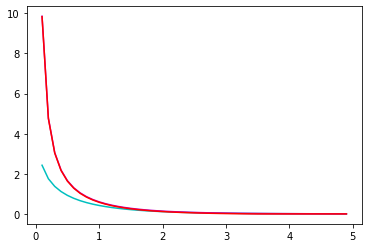

In [46]:
test_kn = torch.tensor(np.arange(0, 5, 0.1), device=device)
out_k0 = torch_scipy_k0(test_kn)
out_k1 = torch_scipy_k1(test_kn)
out_k1_cutoff = torch_scipy_k1_cutoff(test_kn)
fig, ax = plt.subplots()
ax.plot(test_kn.cpu(), out_k0.cpu(), 'c-')
ax.plot(test_kn.cpu(), out_k1.cpu(), 'm-')
ax.plot(test_kn.cpu(), out_k1_cutoff.cpu(), 'r-')

In [47]:
print(test_kn)
print(out_k0)
print(out_k1)
print(k1_cutoff)
print(out_k1_cutoff)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000], device='cuda:1',
       dtype=torch.float64)
tensor([   inf, 2.4271, 1.7527, 1.3725, 1.1145, 0.9244, 0.7775, 0.6605, 0.5653,
        0.4867, 0.4210, 0.3656, 0.3185, 0.2782, 0.2437, 0.2138, 0.1880, 0.1655,
        0.1459, 0.1288, 0.1139, 0.1008, 0.0893, 0.0791, 0.0702, 0.0623, 0.0554,
        0.0493, 0.0438, 0.0390, 0.0347, 0.0310, 0.0276, 0.0246, 0.0220, 0.0196,
        0.0175, 0.0156, 0.0140, 0.0125, 0.0112, 0.0100, 0.0089, 0.0080, 0.0071,
        0.0064, 0.0057, 0.0051, 0.0046, 0.0041], device='cuda:1',
       dtype=torch.float64)
tensor([    

In [48]:
def J_chemMacdonald(xy, d): # cutoff! --> shift the values
    chemMag = torch_scipy_k1_cutoff(kappa * d) *(kappa/(2*np.pi))
    xy = chemMag * xy
    return torch.nansum(xy, dim=0, keepdim=False)    

In [49]:
if periodic:
    def xy2distance(xy, L):
        dx = xy[:, :1] - xy[:, :1].T   # neighbor - target
        dy = xy[:, 1:] - xy[:, 1:].T
        dx = dx % L
        dy = dy % L
        dx[dx > L/2] = dx[dx > L/2] - L
        dy[dy > L/2] = dy[dy > L/2] - L
        return [dx, dy]
else:
    def xy2distance(xy, L):
        dx = xy[:, :1] - xy[:, :1].T
        dy = xy[:, 1:] - xy[:, 1:].T
        return [dx, dy]    

def J_CF(xy, dr, q):
    c = torch.unsqueeze(q[0], 1)   # cos, sin of neighbor
    s = torch.unsqueeze(q[1], 1)
    xy = (1 + xy[:,:,:1] * c + xy[:,:,1:] * s) * xy / 2
    return torch.nansum(xy, dim=0, keepdim=False)

def J_CIL(xy, d, r):
    xy = ((r/d) - 1) * xy
    return torch.nansum(xy, dim=0, keepdim=False)

In [50]:
class SDE(torch.nn.Module):
    noise_type = 'scalar'
    sde_type = 'ito' if isIto else 'stratonovich'

    def __init__(self, L, periodic, v0, beta, A_CF, A_CIL, r, A, D):
        super().__init__()
        self.L = L
        self.periodic = periodic
        self.v0 = v0
        self.beta = beta
        self.A_CF = A_CF
        self.A_CIL = A_CIL
        self.r = r
        self.A = A

        self.sigma = torch.zeros((batch_size, state_size, 1), device=device)
        self.sigma[:, 2, 0] = np.sqrt(2*D)
        
    # Drift
    def f(self, t, y):
#        print(y.shape)
        xy = y[:, :2]
#        if self.periodic:
#            xy = xy % L
        xy = xy2distance(xy, self.L)
#        print(np.shape(xy))
#        print(xy[0].shape)
        xy = torch.cat((torch.unsqueeze(xy[0], 2), torch.unsqueeze(xy[1], 2)), 2)
        d = torch.norm(xy, p='fro', dim=2, keepdim=True)   # distance
        dr = torch.heaviside(self.r - d, torch.tensor([0.0], device=device))   # 1 if distance < r, else 0
        xy = dr * torch.nn.functional.normalize(xy, p=2.0, dim=2)   # normalized distance vector
        c = torch.cos(y[:, 2:])
        s = torch.sin(y[:, 2:])

        jcil = J_CIL(xy, d, self.r)
        
        jchem = J_chemMacdonald(xy, d)
        
        dx0 = self.v0 * torch.cat((c, s), 1)
        dx1 = -self.beta * jcil
        dtheta0 = self.A_CF * J_CF(xy, dr, [c,s]) - self.A_CIL * jcil
        dtheta0 = c * dtheta0[:, 1:] - s * dtheta0[:, :1]
        dtheta1 = self.A * c
        dtheta2 = A_Macdonald * (c * jchem[:, 1:] - s * jchem[:, :1])
        return torch.cat((dx0+dx1, dtheta0+dtheta1+dtheta2), 1)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma


In [51]:
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)

ts = torch.linspace(0, t_max, t_max+1, device=device)

for i_repeat in range(6):
    y0 = torch.rand((batch_size, state_size))
    y0 = torch.cat((y0[:,:2] * L, y0[:,2:] * (2*np.pi)), 1).to(device)


    bm = BrownianInterval(t0=ts[0], 
                          t1=ts[-1], 
                          size=(batch_size, brownian_size),
                          dt=stepSDE,
                          device=device)

    sde = SDE(L, periodic, v0, beta, A_CF, A_CIL, r, A, D)

    ys = sdeint(sde, y0, ts, bm=bm, dt=stepSDE, method=methodSDE)

    now = datetime.datetime.now()

    savedir = paramdir + now.strftime('%Y%m%d_%H%M%S')
    os.makedirs(savedir, exist_ok=True)

    np.savez(os.path.join(savedir, 'result.npz'),
             xy = ys[:,:,:2].cpu().detach().numpy() % L,
             theta = ys[:,:,2].cpu().detach().numpy() % (2*np.pi),
             celltype_label = celltype_label.cpu().detach().numpy())

In [52]:
cm = plt.cm.hsv

@interact(t_plot=(0, ts.size()[0]-1))
def f(t_plot):

  x = ys[t_plot,:,0].cpu().detach().numpy() % L
  y = ys[t_plot,:,1].cpu().detach().numpy() % L
  theta = ys[t_plot,:,2].cpu().detach().numpy() % (2*np.pi)

  fig, ax = plt.subplots()
  plt.title("polarity t = " + str(ts[t_plot].cpu().detach().numpy()))
  ax.set_aspect('equal')
  im = ax.quiver(x, y, np.cos(theta), np.sin(theta), color=quiv_label, scale = 1,scale_units='xy', pivot='mid')
  plt.xlim(0, L)
  plt.ylim(0, L)
  #fig.colorbar(im)
  #im.set_clim(0, 2*np.pi)


interactive(children=(IntSlider(value=500, description='t_plot', max=1000), Output()), _dom_classes=('widget-i…